# RNN For Text Generation

John Sullivan, Daniel Crews 

Recurrent Neural Networks are effective at detecting patterns which makes them a good choice for applications like time series predictions.  This same strength can be leveraged to detect patterns in other types of input, such as language.

The purpose of this project is to utilize neural networks to create text, specifically tweets.  With a corpus of 20,000+ tweets, our goal is to be able to generate text that is similar in style to the the source text.  This is accomplished by first training the network on the corpus and then generating 140 characters starting with a specified phrase to start the sequence.

## Collect the tweets from repository

Our collection of tweets comes @realDonaldTrump as there are a large number of tweets available (in a github repository hosted by user *bpb27*) in the author's distinctive style.

The ```collect_tweets``` function is used to collect the tweets from the repository and unzip them. ```fix_tweets``` handles cleaning up encoded text and the removal of any tweets from the dataset that contain links leaving only tweets with actual prose. The result is a large numpy array that contains all collected tweets, stored as individual characters.

In [1]:
import zipfile
import urllib.request
import html
import json
import re
import numpy as np

URL_F = 'https://github.com/bpb27/trump_tweet_data_archive/raw/master/condensed_{}.json.zip'
TWEET_YEARS = ['2012', '2013', '2014', '2015', '2016', '2017']

regex = re.compile(r'[\r\n\t]')
hypertext = re.compile(r'http')

def fix_tweets(fnames):
    tweets = []
    for fname in fnames:
        with open(fname) as fp:
            for msg in json.load(fp):
                if msg['is_retweet'] or hypertext.search(msg['text']):
                    continue
                text = regex.sub('', html.unescape(msg['text']))
                tweets.extend(list(text))
                tweets.append(' ')
    return np.array(tweets)

def collect_tweets(download = True, years = TWEET_YEARS, dl_years = TWEET_YEARS):
    if download:
        for year in dl_years:
            request = urllib.request.urlopen(URL_F.format(year))
            with open(f'condensed_{year}.json.zip', 'wb') as fp:
                fp.write(request.read())
            with zipfile.ZipFile(f'condensed_{year}.json.zip') as jzip:
                jzip.extractall()
    return fix_tweets([f'condensed_{year}.json' for year in years])

## Preprocessing

After collecting the tweets we create the X and y data sets. Since the neural network works best with numeric data, we use two dictionaries, one which turns the chars into ints and another to reverse the process.

The output layer of the network should be the total number of characters possible in the data set, this is obtained by gathering all the unique characters before processing. Next, targets for each letter of the training set are created by shifting every character to the left. Since the last character doesn't have a "correct" value to check, it is removed.

In [3]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False)
tweets = collect_tweets(download = True) # Collect the tweets

In [4]:
# Dictionaries used to translate the 
char_to_int = {char:ind for ind, char in enumerate(np.unique(tweets))}
int_to_char = {ind:char for ind, char in enumerate(np.unique(tweets))}

# Get the size of the vocab
char_count = len(np.unique(tweets)) # Total number of characters / output size

# Transform the data into numbers for one-hot encode
data = [char_to_int[char] for char in tweets]

# One hot encode the data
data = one_hot.fit_transform(np.reshape(data, (len(data), 1)))

# Split the data into training and test sets
X = data[:-1]
y = data[1:]

## Tensorflow

The network is a two-layer LSTM-cell RNN, with 256 neurons per layer. The Long Short-Term memory cells deal with an issue that plain recurrent neural networks suffer from: vanishing gradients. Indivdual characters, as onehot encoded vectors, are fed to the network as input. Each batch consists of 100 instances, each running for 100 timesteps or characters. 

At each timestep, the next character in the sequence is predicted. In order to make this prediction, the output is a fully connected layer with an output equal to the size of the vocabulary.  Softmax is applied to this final layer to create the probabilities for the next character selected.  At the end of each batch, the predicted characters are compared to the actual to evaluate cost. 

We attempted to deal with the issue of overfitting to phrases like "@realDonaldTrump" by adding dropout between the LSTM cells and the fully connected layer.  Even after training our network down to approximately the same cost value, the results were worse than before dropout was added.  It was no longer overfitting, but it would also miss a letter every other word, a trade off we decided wasn't worthwhile.

### Auxiliary functions

In [5]:
def make_tweet(prefix, tweet_len, one_hot, char_to_int, int_to_char, n_layers, n_neurons, sess):
    
    # Create a zero state to initialize LSTM cell
    prev_state = np.zeros((n_layers, 2, 1, n_neurons))
    
    # Run the selected prefix that begins the tweet
    for i in range(len(prefix)):
        out, prev_state = sess.run([final_outputs, next_state], feed_dict={X: [one_hot.transform(char_to_int[prefix[i]])], init_state: prev_state})

    # Append the prefix to the tweet
    generated = prefix
    
    # Generate character of desired length
    for i in range(tweet_len + 20):
        element = np.random.choice( range(char_count), p=out[0][0] )
        generated += int_to_char[element]
        out, prev_state = sess.run([final_outputs, next_state], feed_dict={X: [one_hot.transform(element)], 
                                                   init_state: prev_state})
        
        # End on a space
        if i > tweet_len and int_to_char[element] == ' ':
            break
    return generated

def round_down(num, divisor):
    return num - (num%divisor)

### Network

In [6]:
# Parameters
n_inputs = char_count
n_outputs = char_count
n_neurons = 256
n_steps = 100
n_layers = 2 

batch_size = 100
learning_rate = 0.001

train_size = round_down(y.shape[0], n_steps)
instance_length = y[:train_size].shape[0] // n_steps

X_train = np.reshape(X[:train_size], (instance_length, n_steps, char_count))
y_train = np.reshape(y[:train_size], (instance_length, n_steps, char_count))

In [7]:
import tensorflow as tf

In [8]:
tf.reset_default_graph()

# Importing and reshaping data
X = tf.placeholder(tf.float32, [None, None, n_inputs])
y = tf.placeholder(tf.int32, [None, None, n_outputs])
y_batch_long = tf.reshape(y, [-1, n_outputs])

init_state = tf.placeholder(tf.float32, [n_layers, 2, None, n_neurons])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
    for idx in range(n_layers)
)

# LSTM
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, state_is_tuple=True) for layer in range(n_layers)]

# Dropout
dropout_cells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.8) for cell in lstm_cells]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells, state_is_tuple=True)

# Iteratively compute output of recurrent network
outputs, next_state = tf.nn.dynamic_rnn(multi_cell, X, initial_state=rnn_tuple_state, dtype=tf.float32)

# Linear activation (FC layer on top of the LSTM net)
network_output = tf.layers.dense(outputs, n_outputs, activation=tf.nn.relu)

# Catch the output for text generation
batch_time_shape = tf.shape(outputs)
final_outputs = tf.reshape( tf.nn.softmax( network_output), (batch_time_shape[0], batch_time_shape[1], n_outputs) )

# Training: provide target outputs for supervised training.
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=network_output, labels=y_batch_long) )
train_op = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost)

## Training

With each epoch we are printing out an example tweet along with the value of the cost function at the time the tweet is created.

With this dataset and network configuration, it takes around 100 epochs before you see results that are mostly free of strange characters and typos.

In [79]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 3
tweet_log = []

with tf.Session() as sess:
    #init.run()
    saver.restore(sess, "./model/last_model.ckpt")
    for epoch in range(n_epochs):
        # A zero tensor to initialize the LSTM cell
        zero_state = np.zeros((n_layers, 2, batch_size, n_neurons))
        
        for iteration in range(len(X_train)//batch_size):
            X_batch = X_train[iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y_train[iteration*batch_size:iteration*batch_size+batch_size]
            cst, _ = sess.run([cost, train_op], feed_dict={X: X_batch, y: y_batch, init_state: zero_state})
            print(f'\rMinibatch: {iteration:3} Cost: {cst:1.2f}', end='')
        print('')
        
        tweet = make_tweet("The ", 139, one_hot, char_to_int, int_to_char, n_layers, n_neurons, sess)
        print(f"Tweet: {tweet}")
        
        tweet_log.append([tweet, cst])
        
        # Save the model
        save_path = saver.save(sess, "./model/last_model.ckpt")

INFO:tensorflow:Restoring parameters from ./model/last_model.ckpt
Minibatch: 260 Cost: 1.03
Tweet: The I13 of the trade in the China to Hillary starting on that the U.S. took racist! I will be doing Fox & Frien Edventision, today. Bernie sand a 
Minibatch: 260 Cost: 1.01
Tweet: The playoffs,things who came! .@MattGinellaGC  Matt and told #Great course!! .@EHPrevidoomPort😡21: Leaving the millions of dollars man,). I am the 
Minibatch: 260 Cost: 1.02
Tweet: The city should not blind viewing down. Now Ted Cruz troops to the very dumb assems. Very successful and angry done." They would have wanthed for 


## Generating tweets

Here we are restoring the most recent model and using it to create tweets.  The `make_tweet` function accepts a text length so you can generate as much text as you would like.

In [74]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Restore the model and create a tweet
with tf.Session() as sess:
    saver.restore(sess, "./model/last_model.ckpt")
    tweet = make_tweet("Roy Moore ", 139, one_hot, char_to_int, int_to_char, n_layers, n_neurons, sess)
    print(f"Tweet: {tweet}")

INFO:tensorflow:Restoring parameters from ./model/last_model.ckpt
Tweet: Roy Moore - I prins of tappe states! Wow, sebsit fighting for adrifice of father of the President." Thank you to all of this to be safetiated" United Sterling 


In [76]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Restore the model and create a tweet
with tf.Session() as sess:
    saver.restore(sess, "./model/last_model.ckpt")
    tweet = make_tweet("The ", 139, one_hot, char_to_int, int_to_char, n_layers, n_neurons, sess)
    print(f"Tweet: {tweet}")

INFO:tensorflow:Restoring parameters from ./model/last_model.ckpt
Tweet: The help of any mintan with easily without it." It doesn't exito! Be totally fired, much of making a stronged & what is for the exant oneing what 


## Tweets over time

To visualize the training process, we plotted the value of the cost function evaluated at each epoch.  Every 20 epochs we display an example tweet at that level of trianing.  As you can see, the LSTM learns that there are structures like words very quickly, but it takes a fair bit more trianing to start getting results that are english.

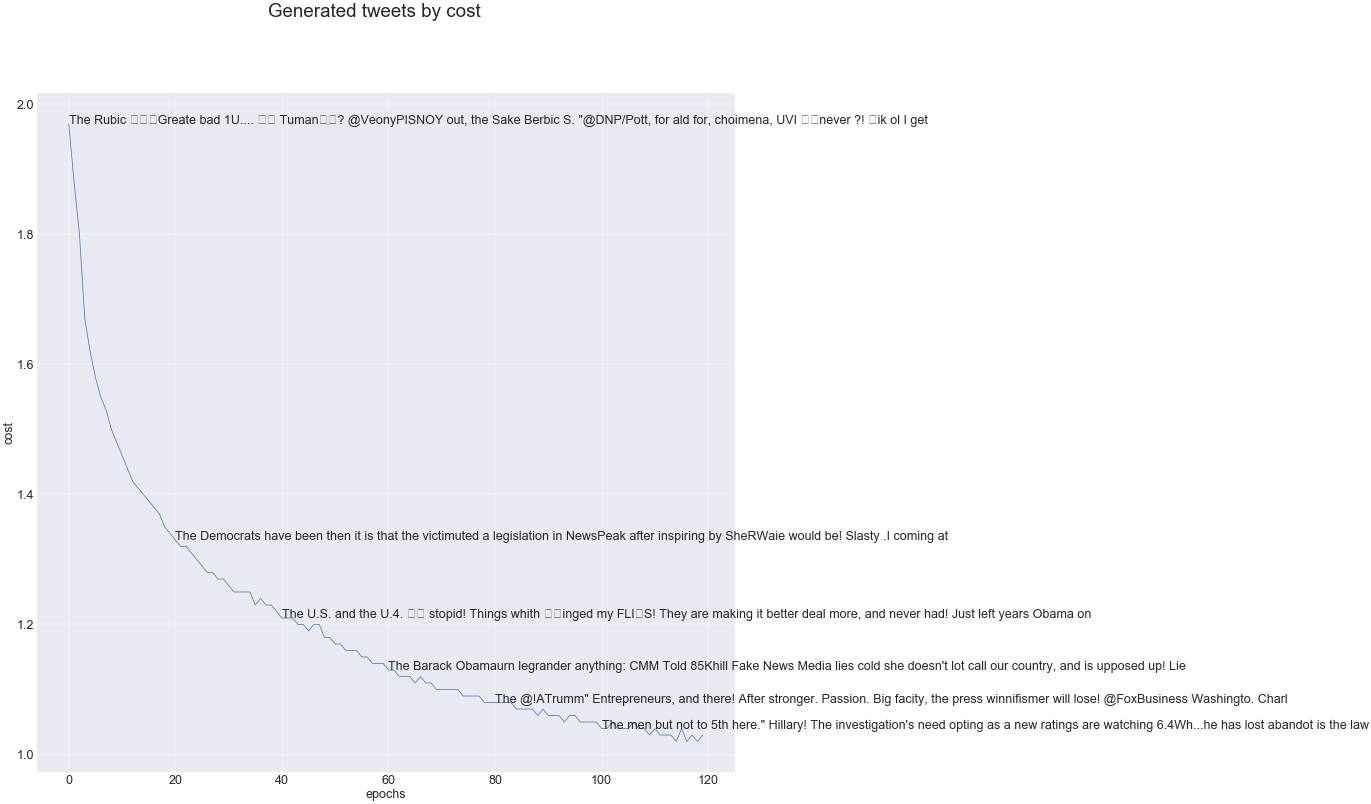

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

tl = pd.read_csv('tweets.csv', sep=',', quotechar='`').values

plt.figure(figsize=(30, 30), dpi=30)
plt.suptitle('Generated tweets by cost', fontsize=45)
ax = plt.subplot()

ax.set_ylabel('cost', fontsize=30)
ax.set_xlabel('epochs', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

ax.plot(tl[:,0])

for idx,pair in enumerate(tl):
    if not idx % 20:
        ax.annotate(pair[1], (idx,pair[0]), fontsize=30)

## Results

After 100+ epochs of training, it seems the network shares at least some grammatical style and vocabulary with the President's twitter account. Although the messages themselves are fairly nonsensical, they bear some visual resemblence to the real article, which is what we had set out to do originally.

With the special election in Alabama turning up a surprising result, we wanted to ask our new Trumpbot how it felt about the candidates.  This yeilded some of our favorite results:

>Doug Jones are using the incompetent and back to Super Monthman Steep and so many go? Great job on @nbc @FoxNews but we've said that took lead trade!

-

>Moore is being released. Not even close. Can we mate must be announce that it's donely high failure of winning 94,000 fuch atclited to learn!

-

>Jones tonight! The Democrats... CAFFO. I will not want to take in a different lightment said I will leave for America! He had to see the brave!

## Conclusion

The results aren't exactly what we were expecting, but it's surprising that a method this simple works as well as it does. It's interesting to see it even replicate some quality of the given input. If we were to attempt this again, some more research into methodologies for using text as input to an RNN may help, as most of the examples we came across were pretty dense and didn't well suit our application.